# Understanding the Grover Search on a $2^{N}$ Space

##### This document is meant as an illustrative guide into the Grover Algorithm, and its application as a search algorithm.  It goes over both the theory and realization of the Grover Algorithm, with plenty of working examples.

_______________________________________________________________________________________________

## Getting Started
------------------------------------

This code is dependant on Python 3.5 or greater, as well as the 'Project Q' files found from the Github project:

https://github.com/ProjectQ-Framework/ProjectQ

In order to make sure all of the modules import correctly, make sure that this file is being run within the same directory as the folder called 'projectq.'  

I reccomend downloading the Github project, creating a new folder somewhere (i.e. 'Project Q Code' located on your Desktop), and copying the folder 'projectq' from the Github zip file into your new created folder.  Then, make sure that this .ipynb file is located in your created folder, along with 'projectq.'

In [4]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import projectq as Q
from projectq.ops import H,X,Z,Measure,All
from projectq.meta import Control,Compute,Uncompute,Loop
from projectq.backends import Simulator

if(Q,np,plt,math,random):
    print("Successfully Imported Modules")

Successfully Imported Modules


## What is the Grover Algorithm?
---

Grover's Algorithm is a quantum algorithm that can be thought of as searching through an un-ordered list.  Imagine you want to look someone up in a directory, which is alphabetically ordered by last name, but you only have their first name.  In this scenario, you are stuck going through each entry one at a time, until you eventually happen upon the person you are looking for.

Exhaustively searching through the database represents the classical approach, which requires on average $\frac{N}{2}$ evaluations, which is of the order *O*($N$) for a classical algorithm.  By instead using the Grover Algorithm, we can complete this search (with a high success probability) using only *O*($\sqrt{N}$) evaluations.

## Setting Up the Problem
---

This document contains a simple code that demonstrates running a Grover Search on a $2^{N}$ space.  Specifically, our algorithm will allow us to pick any state we want (within the $2^{N}$ space), and then attempt to find that state with a measurement.

Like the classical search, our quantum algorithm needs to start in an equal superposition of all states, representing having no *a priori* knowledge of where the marked entry is located.  So to start off our algorithm, we need to specify the size of our problem, and then create an equal superposition Hilbert Space.  The code below does exactly this.

N = an integer, which will be used to create $2^{N}$ states 

eng = the quantum engine, which will create the qubits

qureg = the quantum register, which stores the state of our system (N qubits)

In [12]:
N = 4    #recommened example:   N=4

eng = Q.MainEngine()
qureg = eng.allocate_qureg(N)

(Note: This is the (slow) Python simulator.)


So far we have created our quantum system, consisting of N qubits, but have not yet created an equal superposition of $2^{N}$ states.  Allocating new qubits to the quantum register puts them initially in the state |$0 \rangle$, which means that so far we have created the following system:

$$| \Psi \rangle = |0 \rangle |0 \rangle ... |0 \rangle$$

or

$$| \Psi \rangle = |00...0 \rangle $$

So in order to get our desired state, we will apply the following operation on our system:

$$H^{\otimes N} | \Psi \rangle = \frac{1}{\sqrt{2^{N}}} \sum_{i=0}^{2^{N}-1} |i \rangle $$

which can be implementing in our code by using All(H) | qureg:

In [13]:
All(H) | qureg

where H is a Hadamard Gate:

$$ H |0\rangle = \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) \\
   H |1\rangle = \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) $$

To test that we really have achieved an equal superposition, we can measure our system and view the results:

In [14]:
All(Measure) | qureg
eng.flush()

state = np.zeros(N)
for i in np.arange(N):
    state[i] = int(qureg[i])
    
print("Measured The State: ",state)

Measured The State:  [1. 1. 0. 1.]


Try re-running the 3 previous cells of code a few times, and seeing the different measurement results.  We need all three cells of code each time, because the act of measuring the qureg in cell 3 collapses our system down to a single state.  Thus, we need to repeat code cells 1 and 2 to re-prepare an equal superposition each time.

Measure | = performs a measurement on the specified state, in this case the state of the system stored in qureg (|$  \Psi \rangle$)

.flush() = a function that deallocates all the qubits in the system.  This is an important final step after making measurements

int(qureg[i]) = after a measurement has been made, we can view the final state of each qubit (either |$0\rangle$ or |$1\rangle$) as an integer

### Plotting An Equal Superpositon
---

Let's recombine the 3 previous code cells into 1, and generate multiple measurement results in order to make a plot.  In addition, we are also going to create two quick functions:  

1) State_Number - convert the binary value of a state, into an integer, for ease of viewing the results.  For example:

$$ |0110\rangle \implies |6\rangle $$

2) Bins - creates a vector 'bins' that will be used for plotting results nicely

(Note: This is the (slow) Python simulator.)


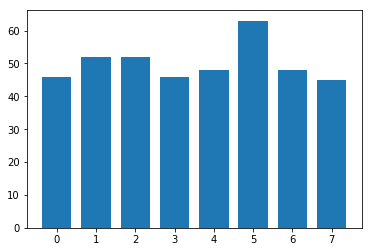

In [16]:
#-------------------------- Functions -------------------------------
def State_Number(vec):
    '''
    Take in a binary vector representing the state measured
    Returns an integer for the coressponding state
    '''
    N = len(vec)
    n = 0
    for i in np.arange(len(vec)):
        if(int(vec[i])==1):
            n = n + 2**( N-1-int(i) )
    return n

def Bins(states):
    '''
    Takes in an integer representing the total number of states for plotting
    Returns an array for plotting a histogram of results
    '''
    vec = np.zeros(states+1)
    b = -0.5
    for i in np.arange(states+1):
        vec[i] = b
        b = b + 1.0
    return vec

#----------------------- Running The Code ----------------------------

N = 3
shots = 400
Measurement_Results = np.zeros(shots)
state = np.zeros(N)

eng2 = Q.MainEngine()
for i in np.arange(shots):
    qureg2 = eng2.allocate_qureg(N)
    All(H) | qureg2
    All(Measure) | qureg2
    eng2.flush()
    for j in np.arange(N):
        state[j] = int(qureg2[j])
    Measurement_Results[i] = State_Number(state)

bins_plot = Bins(2**N)
plt.hist(Measurement_Results,bins_plot,rwidth=0.75)
plt.show()

The code above should produce an easy to read histogram, where all of the states in the system appear with equal probability (subject to randomness).  Be sure to try and fully understand this code before moving on.  Change the parameters 'N' and 'shots' to get a feel for different results.

## Implementing an Oracle
---

Now that we know how to create an equal superposition of $2^{N}$ states, it is time to move forward with implementing the Grover Search.

The first thing we need is an operator $U_w$, known as an 'oracle.'  Simply put, this is an operator that picks out a single state in the system, say |$0101\rangle$, where we can choose which state to pick out (this is how we are going to choose which state we want to search for).

More specifically, we want to pick out the state of interest |$x_o\rangle$ and then flip its phase from +1 to -1, but leave all other states |$x\rangle$ in the system untouched:

$$ U_w |x_o\rangle = -|x_o\rangle$$
$$ U_w |x\rangle = |x\rangle$$

We are going to achieve this desired result as follows:

1) We will attach an ancilla qubit to our system

2) Put the ancilla in the state |$-x\rangle$, where |$\pm x \rangle = \frac{1}{\sqrt{2}} ( $|$0\rangle \pm $|$1\rangle )$

3) Use the desired state $|x_o \rangle$ in a CNOT (control-not) gate to apply an X gate to the ancilla, where:

$$ X|0\rangle = |1\rangle $$
$$ X|1\rangle = |0\rangle $$

This methodology works because of what happens when we apply an X gate to the state $|-x\rangle$:

$$ X |-x \rangle = X \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) $$
$$ = \frac{1}{\sqrt{2}}( |1\rangle - |0\rangle ) $$
$$ = -|-x\rangle $$

The X operator takes the state |$-x\rangle \rightarrow -$|$-x\rangle$.  And if we can apply this operation on the ancilla, for only the desired state |$x_o\rangle$:

$$ |x_o\rangle X |-x\rangle \rightarrow |x_o\rangle (-1) |-x\rangle $$

$$ = (-1) |x_o\rangle |-x \rangle $$

then we will have successfully marked the desired state, and we can discard the ancilla.

Steps 1 and 2 can be implemented using the following code:

In [17]:
N = 4   
eng = Q.MainEngine()
qureg = eng.allocate_qureg(N)

ancil = eng.allocate_qubit()     #1

X | ancil                        #2
H | ancil

(Note: This is the (slow) Python simulator.)


eng.allocate_qubit() = adds another qubit to our system, stored as 'ancil' rather than in qureg

X | ancil = puts the ancilla qubit in the state |$1\rangle$

H | ancil = puts the ancilla qubit in the state |$-x\rangle$

Step 3 is a little trickier to implement.  We need to pick out only the state $|x_o\rangle$ of our choosing.  We can do this with a CNOT gate, which can be thought of like a quantum anaolgy to an "if statement."  Essentially, we want an application like: if( |$x_o\rangle$ ) $\rightarrow$ X|$-x\rangle$ 

But a CNOT gate is not exactly like an if statement, it works as follows:

$$ |0\rangle |0\rangle \rightarrow |0\rangle |0\rangle $$
$$ |0\rangle |1\rangle \rightarrow |0\rangle |1\rangle $$
$$ |1\rangle |0\rangle \rightarrow |1\rangle |1\rangle $$
$$ |1\rangle |1\rangle \rightarrow |1\rangle |0\rangle $$

where the first state is the 'control qubit', and the second state is the 'target qubit.'  These roles can be reversed if desired, but every CNOT gate needs at least one control and target.  As can be seen by the four possibilities above, when the control qubit is in the state |$0\rangle$, the target qubit is unchanged.  Conversely, when the control qubit is in the state |$1\rangle$, the target qubit is flipped (or acted on by an X gate).

To use a CNOT operation for our oracle, we will use the state |$x_o\rangle$ as the control, and the ancilla qubit as the target.  For states of higher order, the CNOT gate works the same, only each control qubit must be in the state |$1\rangle$.  For example:

$$ CNOT |111\rangle |0\rangle \rightarrow |111\rangle |1\rangle $$
$$ CNOT |101\rangle |0\rangle \rightarrow |101\rangle |0\rangle $$

In the second case, qubit 2 is in the state |$0\rangle$, so no change is applied to the target

Thus by default, the CNOT gate can be used in our oracle operator for the state |$11...1\rangle$, but not for any other state.  Since we want our algorithm to be flexible (we can choose any state |$x_o\rangle$ to be the marked state), we will implement the following strategy:

1) We transform our picked state |$x_o\rangle \rightarrow $ |$11...1\rangle$

2) Apply the CNOT operation, resulting in |$-x\rangle \rightarrow -$|$-x\rangle$ for the ancilla (for that state only)

3) Transform back: |$11...1\rangle \rightarrow $ |$x_o\rangle$

This is achieved by the following function:

In [18]:
def Oracle(eng,qureg,ancil,state):
    '''
    Takes in Main Engine (eng), quantum register (qureg), ancilla qubit (ancil)
    Takes in a binary vector representing the state to be marked by the oracle (state)
    Returns the quantum system after applying the X gate to the ancilla qubit
    '''
    for i in np.arange( len(state) ):      #flip all 0's to 1's in the locations specified by state
        if( int(state[i]) == 0 ):
            X | qureg[i]
    with Control(eng,qureg):               #the state |111..> will then apply X gate to the ancilla
        X | ancil
    for i in np.arange( len(state) ):      #transform all the states in qureg back
        if( int(state[i]) == 0 ):
            X | qureg[i]

This function is a little tricky to understand at first, so I recommened studying it carefully before moving on.  In essence:

state is a vector representing the desired state |$x_o\rangle$, for example: state = [0,1,0,1]

The for loops in this function basically go through each term in state (each position represents a qubit), and if the value is 0, applies an X operator to the qubit in that location.  It is important to note that this is transforming every state in the system.

Consider how this would affect the following three states, for the 0 located in the position state[2], in the example above:

$$ |0100\rangle + |0101\rangle + |0110\rangle \rightarrow |0110\rangle + |0111\rangle + |0100\rangle$$

In the end, only the state initially in |$0101\rangle \rightarrow$ |$1111\rangle$ (the |$x_o\rangle$ that we chose), which is exactly what we need.  Every other state in the system gets mapped to some state with at least one 0.


By transforming all the states in the system in this way, we can then use a CNOT gate, and make sure that only the desired state |$x_o\rangle$ will pick up a negative sign.  This is achieved by the code:

with Control(eng,qureg):

which is a function that uses the entire system represented by qureg as the control. Sidenote: If for instance we only wanted to use the first 2 qubits as the control, we could do something like:

with Control(eng,qureg[0:2]):

which we will be doing something similar later.


Putting it all together, we can now implement a code that achieves the following:

$$H^{\otimes N} | \Psi \rangle = \frac{1}{\sqrt{2^{N}}} \sum_{i=0}^{2^{N}-1} |i \rangle \rightarrow \frac{1}{\sqrt{2^{N}}} \sum_{i=0, i \neq x_o}^{2^{N}-1} |i \rangle - \frac{1}{\sqrt{2^{N}}}|x_o\rangle $$

In [20]:
#-------------------------- Functions -------------------------------
def Binary_State(n,N):
    '''
    Take in an integer representing a state (n)
    Returns a binary vector for that corresponding state
    '''
    vec = np.zeros(N)
    nn = n*1.0
    for i in np.arange(N):
        q = nn/( 2**( N-1-int(i) ) )
        if( q >= 1.0 ):
            vec[i] = 1
            nn = nn - 2**( N-1-int(i) )
    return vec

#----------------------- Running The Code ----------------------------

N = 2
Xo = 1
marked = Binary_State(Xo,N)


eng3 = Q.MainEngine()
qureg3 = eng3.allocate_qureg(N)
All(H) | qureg3

ancil3 = eng3.allocate_qubit()
X | ancil3
H | ancil3
Oracle(eng3,qureg3,ancil3,marked)
All(Measure) | qureg3
Measure | ancil3
eng3.flush()

(Note: This is the (slow) Python simulator.)


To see that this code really does marked the desired state with the function Oracle, run the following code below.  Rather than the ancilla being in the state |$-x\rangle$, if we instead leave the ancilla in the state |$0\rangle$, the act of our oralce will achieve the following results:

$$ |x_o\rangle |0\rangle \rightarrow |x_o\rangle |1\rangle $$

which we can observe with a measurement on the system:

In [33]:
N = 2
Xo = 3
marked = Binary_State(Xo,N)


eng4 = Q.MainEngine()
qureg4 = eng4.allocate_qureg(N)
All(H) | qureg4

ancil4 = eng4.allocate_qubit()

Oracle(eng4,qureg4,ancil4,marked)

Measure | ancil4
All(Measure) | qureg4
eng4.flush()

state = np.zeros(N)
for j in np.arange(N):
    state[j] = int(qureg4[j])

print("Measured State: ",State_Number(state))
print("Ancilla State:  ",int(ancil4))

(Note: This is the (slow) Python simulator.)
Measured State:  3
Ancilla State:   1


Run the above code several times, until you observe a measurement result of Xo.  When the state |$x_o\rangle$ is measured, the ancilla will be in the state |$1\rangle$, and for any other measurement result, the ancilla will be in the state |$0\rangle$.

## Grover Diffusion Operator
---

Now that we have the our oracle function $U_w$, all we need now is $U_s$, known as the Grover diffusion operator.

$$ U_s = 2|s\rangle \langle s | - I $$
where |$s\rangle$ is the superposition of all states:
$$ |s\rangle = \frac{1}{\sqrt{2^{N}}} \sum_{i=0}^{2^{N}-1} |i \rangle $$

$U_s$ can be described as a reflection about the mean of the system (|$s\rangle$).  So in order to achieve this reflection, we are going to invoke the following strategy:

1) Map the state |$s\rangle \rightarrow$ |$00...0\rangle$

2) Reflect around |$00...0\rangle$

3) Map back to the original basis

The code that will be implementing $U_s$ is as follows:

In [27]:
def Grover_Diffusion(eng,qureg):
    '''
    Takes in Main Engine (eng) and quantum register (qureg)
    Returns the quantum system after reflecting about the mean
    '''
    All(H)|qureg                   #1) Maps |s> ---> |00...0>
    
    All(X)|qureg                   
    with Control(eng,qureg[0:-1]): 
        Z|qureg[-1]                #2) Reflects around the state
    All(X)|qureg
    
    All(H)|qureg                   #3) Maps back to the original basis

Like the Oracle function, how the above code achieves the operator $U_s$ is tricky to understand at first, so we will go through it step by step here:

Recall earlier that $H^{\otimes N}$ transformed our quantum system from the state |$00...0\rangle$ to an equal superposition of all states, |$s\rangle$.  By applying this same operator on $|s\rangle$, we achieve the reverse result:

$$ H^{\otimes N} |s\rangle = |00...0\rangle $$

Thus, the first step in our function is to apply All(H) | qureg.

Next, we want to perform a reflection about the state |$00...0\rangle$: 

$$|00...0\rangle \rightarrow -|00...0\rangle$$

To do this, we invoke a series of steps similar to the oracle function.  First, we apply X gates to all the qubits in the system (All(X) | qureg).  This maps our state |$00...0\rangle \rightarrow$ |$11...1\rangle$ (along with mapping all of the other states in the system accordingly).  Then, we use a CNOT gate that calls all of the qubits in qureg expect the final one, as the control, and the last qubit as the target.  Specifically, the target qubit gets acted on by a Z gate, which is defined as follows:

$$ Z|0\rangle \rightarrow |0\rangle $$
$$ Z|1\rangle \rightarrow -|1\rangle $$

The line of code 'with Control(eng,qureg[0:-1]):' will call upon exactly two states in the system, in the following way:

$$ |11...11\rangle \rightarrow -|11...11\rangle $$
$$ |11...10\rangle \rightarrow |11...10\rangle $$

Thus, our CNOT operation achieves the desired result of applying a negative phase shift (reflection about the state).  Then, since we initially transformed all of the states will X gates, we need to map them back with an All(X) | qureg.  In summary, we achieve step 2 of the Grover diffusion operator as follows:

$$ |00...0\rangle \rightarrow |11...1\rangle \rightarrow -|11...1\rangle \rightarrow -|00...0\rangle  $$

And lastly, step 3 is mapping back to our original basis, which we achieve by appying $H^{\otimes N}$ to the system: All(H) | qureg

## Implementing The Grover Search
---

We now have everything needed to implement a Grover Search on a $2^{N}$ sized system.  The actual flow of a Grover Search involves applying the $U_w$ and $U_s$ operators $O(\sqrt{2^{N}})$ times, and then making a measurement.  Specifially, the optimal number of repetitions is ~$\frac{\pi}{4}\sqrt{2^{N}}$.

Our complete Grover Search code is as follows:

In [36]:
N = 4
Xo = 11
marked = Binary_State(Xo,N)
steps = int( (math.pi/4)*math.sqrt(2**N) )

eng5 = Q.MainEngine()
qureg5 = eng5.allocate_qureg(N)
All(H) | qureg5

ancil5 = eng5.allocate_qubit()
X | ancil5
H | ancil5

with Loop(eng5,steps):
    Oracle(eng5,qureg5,ancil5,marked)
    Grover_Diffusion(eng5,qureg5)   

Measure | ancil5
All(Measure) | qureg5
eng5.flush()

state = np.zeros(N)
for j in np.arange(N):
    state[j] = int(qureg5[j])

print("Measured State: ",State_Number(state))

(Note: This is the (slow) Python simulator.)
Measured State:  11


With high probability, the above code will measure the marked state, the desired result for a Grover Search.

In order to appreciate these high probabilities, we can run many experiments and plot the results:

(Note: This is the (slow) Python simulator.)


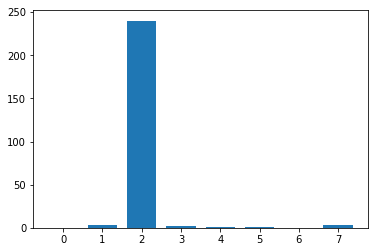

In [38]:
def Grover_Search(eng,qureg,ancil,N,state):
    '''
    Takes in Main Engine (eng), quantum register (qureg), ancilla qubit (ancil), number of qubits (N), and the desired state (state)
    Returns quantum system (qureg and ancil) after performing the Grover Algorithm after an optimal number of steps
    '''
    marked = Binary_State(state,N)
    steps = int( (math.pi/4)*math.sqrt(2**N) )
    
    All(H) | qureg
    X | ancil
    H | ancil
    
    with Loop(eng,steps):
        Oracle(eng,qureg,ancil,marked)
        Grover_Diffusion(eng,qureg)
    return qureg,ancil
        
#-------------- Running The Code ---------------

N = 3
Xo = 2
shots = 250
Measurement_Results = np.zeros(shots)

eng6 = Q.MainEngine()
for i in np.arange(shots):
    qureg6 = eng6.allocate_qureg(N)
    ancil6 = eng6.allocate_qubit()

    qureg6,ancil6 = Grover_Search(eng6,qureg6,ancil6,N,Xo) 

    Measure | ancil6
    All(Measure) | qureg6
    eng6.flush()

    state = np.zeros(N)
    for j in np.arange(N):
        state[j] = int(qureg6[j])
    Measurement_Results[i] = State_Number(state)

bins_plot = Bins(2**N)
plt.hist(Measurement_Results,bins_plot,rwidth=0.75)
plt.show()

This concludes our implementation of the Grover Algorithm into Python code!  I encourage anyone to keep playing around with the code, generating all kinds of results, and really getting a feel for the power of this algorithm.

## Acknowledgements
---

Special thanks to the team that created Project Q, and all of the great code they put together for writing quantum algorithms in Python

Author: Daniel Koch - dkochsjsu@gmail.com

Collaborator: Dov Fields, Hunter College - New York City